In [20]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils

import scipy.signal as signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
G_ds = xr.open_dataset('Outputs/G_ds.nc4')['tas']
G_mean_ds = xr.open_dataset('Outputs/G_mean_ds.nc4')['tas']


In [22]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)
A = utils.find_area(ds_out)

In [23]:
GFDL_mod= G_ds.weighted(A).mean(dim = ['lat','lon']).sel(model = 'GFDL')

In [49]:
tas_pct = pd.read_csv('zecmip_data/tas_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', header = None, index_col = 0)
nbp_pct = pd.read_csv('zecmip_data/nbp_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', header = None, index_col = 0)
co2_pct = pd.read_csv('zecmip_data/co2_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', header = None, index_col = 0)
fgco2_pct = pd.read_csv('zecmip_data/fgco2_GFDL-ESM2M_esm-bell-750PgC_1861_2360.csv', header = None, index_col = 0)

In [50]:
fg_co2_pictrl_ds = xr.open_mfdataset('cmip6_data/fgco2_Omon_GFDL-ESM4_esm-piControl*')
nbp_pictrl_ds = xr.open_mfdataset('cmip6_data/nbp_Lmon_GFDL-ESM4_esm-piControl*')
#co2_pictrl_ds = xr.open_mfdataset('cmip6_data/co2_Amon_GFDL-ESM4_esm-piControl*')
tas_pictrl_ds = xr.open_mfdataset('cmip6_data/tas_Amon_GFDL-ESM4_esm-piControl*')

In [51]:
co2_ppm_to_kg = 2.124 #GtC/ppm

co2_pictrl_ds['co2']*= co2_ppm_to_kg

In [52]:
co2_pct*= co2_ppm_to_kg

In [54]:
#define our output grid size

ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-89.5, 90.5, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
        "lat_b": (["lat_b"], np.arange(-90.,91.,1.0)),
        "lon_b":(["lon_b"], np.arange(.5, 361.5, 1.0))
    }
)

fg_co2_pictrl_ds = utils._regrid_ds(fg_co2_pictrl_ds, ds_out)
nbp_pictrl_ds = utils._regrid_ds(nbp_pictrl_ds, ds_out)
#co2_pictrl_ds = utils._regrid_ds(co2_pictrl_ds, ds_out)
tas_pictrl_ds = utils._regrid_ds(tas_pictrl_ds, ds_out)

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [55]:
#co2_pictrl_ds = co2_pictrl_ds.weighted(A).mean(dim = ['lat','lon','plev'])
nbp_pictrl_ds = nbp_pictrl_ds.weighted(A).sum(dim = ['lat','lon'])
fg_co2_pictrl_ds = fg_co2_pictrl_ds.weighted(A).sum(dim = ['lat','lon'])
tas_pictrl_ds = tas_pictrl_ds.weighted(A).mean(dim = ['lat','lon'])

In [56]:
emis_pictrl = co2_pct.iloc[0].values + nbp_pictrl_ds['nbp'] + fg_co2_pictrl_ds['fgco2']

In [57]:
emis_1pct = co2_pct + nbp_pct + fgco2_pct

In [58]:
times = pd.date_range('2000', periods=len(tas_pictrl_ds['time'][:12*100]), freq='MS')
weights = times.shift(1, 'MS') - times
weights = xr.DataArray(weights, [('time', tas_pictrl_ds['time'][:12*100].values)]).astype('float')


In [59]:
tas_pictrl_ds = (tas_pictrl_ds*weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

In [60]:
emis_pictrl = (emis_pictrl*weights).groupby('time.year').sum('time')/weights.groupby('time.year').sum('time')

In [61]:
emis_dif = emis_1pct.iloc[:100][1].values - emis_pictrl.values

In [62]:
emis_dif

array([ 19.48776287,  15.38907603,   4.27070161, -18.94546155,
        -5.81835519,  16.31464028,  45.79818021, -25.19953491,
       -25.20545377,  12.08249963,  12.62296094, -18.84017677,
       -24.15786471,   3.64667924,  41.34173826, -26.82732307,
        -2.18648792,  28.04456124,   8.42679163,  18.66936149,
         7.92393239,  44.2669943 ,  31.95604255,  10.56140488,
        31.91618132,  52.30292619,  45.99501493,  48.15674754,
        36.27375513,   5.67106163,  72.00618677,  84.33627051,
        46.18802431,  55.53286432,  78.08727979, 115.68170821,
        54.92477287, 103.05521743, 136.85003911, 127.88522774,
        87.22886114, 106.79336392, 164.12179131, 214.84981477,
       151.39162622, 127.35786737, 188.53391568, 188.88574078,
       207.53987988, 191.17938104, 211.41636854, 200.68623912,
       246.87215194, 263.43427702, 250.82708822, 262.20582056,
       259.27493549, 247.77115836, 267.88325394, 295.73048243,
       313.0196895 , 272.47035398, 275.47175764, 270.01

In [65]:
 emis_pictrl.values

array([591.06684108, 595.16566456, 607.88090791, 634.94931088,
       621.05019518, 596.17167758, 567.85018908, 640.36085862,
       641.14409743, 603.81246191, 600.78272473, 631.28760349,
       642.92933426, 610.66087743, 570.850361  , 645.99327871,
       622.54914484, 586.61004136, 609.48977267, 603.75454782,
       619.1379575 , 588.60182275, 604.04791375, 626.18621048,
       609.03261723, 590.95488639, 600.41196088, 607.1750626 ,
       626.30031175, 649.13052686, 588.50213322, 583.97952564,
       634.14628189, 632.69327384, 616.78833195, 580.87442445,
       652.34088941, 612.38057943, 586.59745216, 596.74259658,
       640.82166942, 631.92850173, 584.10167199, 544.05184974,
       623.58893892, 653.75946807, 595.57539508, 607.40014307,
       609.78436483, 634.37086634, 612.96123342, 631.2060363 ,
       595.38272833, 589.99320907, 615.34562356, 602.54634354,
       612.11530524, 632.10905138, 617.51441921, 593.94253743,
       580.00565838, 635.59856968, 632.52458334, 630.12

In [63]:
emis_1pct.iloc[:100][1].values

array([610.55460395, 610.55474059, 612.15160951, 616.00384933,
       615.23183999, 612.48631786, 613.64836929, 615.16132371,
       615.93864366, 615.89496154, 613.40568566, 612.44742672,
       618.77146955, 614.30755667, 612.19209926, 619.16595564,
       620.36265692, 614.6546026 , 617.9165643 , 622.42390931,
       627.06188989, 632.86881705, 636.00395629, 636.74761535,
       640.94879855, 643.25781258, 646.40697581, 655.33181014,
       662.57406688, 654.80158849, 660.50831999, 668.31579615,
       680.33430621, 688.22613816, 694.87561174, 696.55613266,
       707.26566228, 715.43579686, 723.44749127, 724.62782432,
       728.05053056, 738.72186564, 748.2234633 , 758.90166451,
       774.98056514, 781.11733545, 784.10931076, 796.28588386,
       817.32424471, 825.55024738, 824.37760196, 831.89227542,
       842.25488027, 853.42748609, 866.17271178, 864.7521641 ,
       871.39024074, 879.88020974, 885.39767315, 889.67301986,
       893.02534788, 908.06892366, 907.99634098, 900.14

co2_pictrl_ds['co2'].sum(dim = 'plev').plot()

emis_pictrl.values

emis_1pct.iloc[:100][1].values

emis_dif

In [66]:
conv_1pct = signal.convolve(emis_dif, np.array(GFDL_mod), 'full')

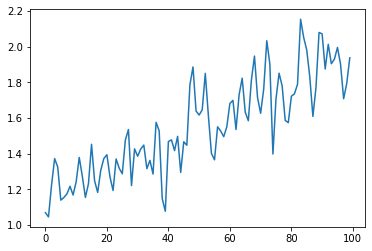

In [67]:
plt.plot(tas_pct.iloc[0:100][1].values - tas_pictrl_ds['tas'].values)

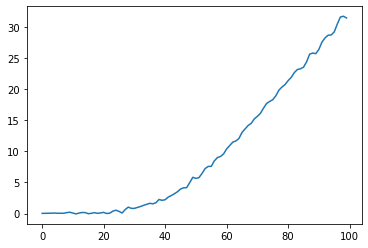

In [68]:
plt.plot(conv_1pct)
